## SARIMAX_base_HAC rivisto con Pulse Dummy sugli outlier

Dall'analisi di SARIMAX_base_HAC_pulse si è confermato che i parametri della componente ARMA hanno un’elevata significatività statistica, ma il coefficiente della pulse dummy per marzo 2022, qualunque sia la lunghezza (3, 2 e 1 mese) risulta **non statisticamente significativo** (quella ad 1 mese lo risulta solo con significatività a 10%). Questo ha portato a ritenere che probabiomente lo shock di marzo 2022 è già assorbito efficacemente dalla specificazione del modello scelto.

Si è dunque analizzato manualmente il dataset del NIC destagionalizzato, e sono stati trovati due **outlier** dalla magnitudine considerevole: ottobre 2022 (+3,9%) e gennaio 2022 (+1,7%). Si è dunque ritenuto opportuno indagare questi due outliers con due **pulse dummies**.

>>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Dummies Outlier e Errori Robusti <<<

I risultati di questo script verranno salvati in: '/Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_outliers_v6'

--- Caricamento Serie Stazionarie da: /Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2/indici_gt_nic_stazionari_fase2.csv ---
Serie caricate con successo. Shape: (252, 3)
Serie inflazione caricata: 251 osservazioni da 2004-02 a 2024-12

--- Creazione Potenziali Dummies di Intervento ---
Creata dummy di IMPULSO: d_outlier_2022_01_pulse1m (valore 1 da 2022-01-01 a 2022-01-01, 1 mesi)
Creata dummy di IMPULSO: d_outlier_2022_10_pulse1m (valore 1 da 2022-10-01 a 2022-10-01, 1 mesi)
Creata dummy di IMPULSO: d_guerra_2022_03_pulse3m (valore 1 da 2022-03-01 a 2022-05-01, 3 mesi)

--- Dummies Selezionate per questa Esecuzione ---
Variabili esogene (dummies) da includere nel modello:
 - d_outlier_2022_01_pulse1m (somma: 1.0)
 - d_outl

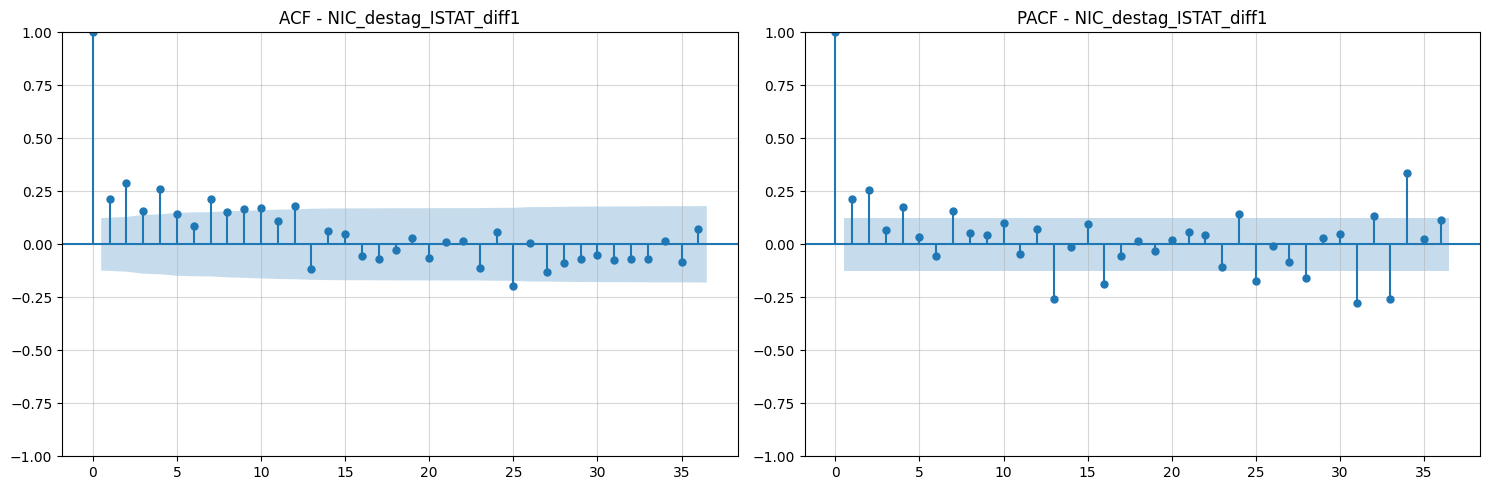


--- Inizio Grid Search (con dummies: d_guerra_2022_03_pulse3m_d_outlier_2022_01_pulse1m_d_outlier_2022_10_pulse1m) ---

=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: AIC) ===
Variabile/i Esogena/e Inlcusa/e: d_outlier_2022_01_pulse1m, d_outlier_2022_10_pulse1m, d_guerra_2022_03_pulse3m
Range ordini: p<=2, q<=2, P<=1, Q<=1 | d=0, D=0, s=12
Numero totale di combinazioni da testare: 36
Sto testando il modello 1/36: SARIMA(0, 0, 0)(0, 0, 0, 12)...
Sto testando il modello 5/36: SARIMA(0, 0, 1)(0, 0, 0, 12)...
Sto testando il modello 9/36: SARIMA(0, 0, 2)(0, 0, 0, 12)...
Sto testando il modello 13/36: SARIMA(1, 0, 0)(0, 0, 0, 12)...
Sto testando il modello 17/36: SARIMA(1, 0, 1)(0, 0, 0, 12)...
Sto testando il modello 21/36: SARIMA(1, 0, 2)(0, 0, 0, 12)...
Sto testando il modello 25/36: SARIMA(2, 0, 0)(0, 0, 0, 12)...
Sto testando il modello 29/36: SARIMA(2, 0, 1)(0, 0, 0, 12)...
Sto testando il modello 33/36: SARIMA(2, 0, 2)(0, 0, 0, 12)...
Sto testando il modello 36/36: SARIMA(2,

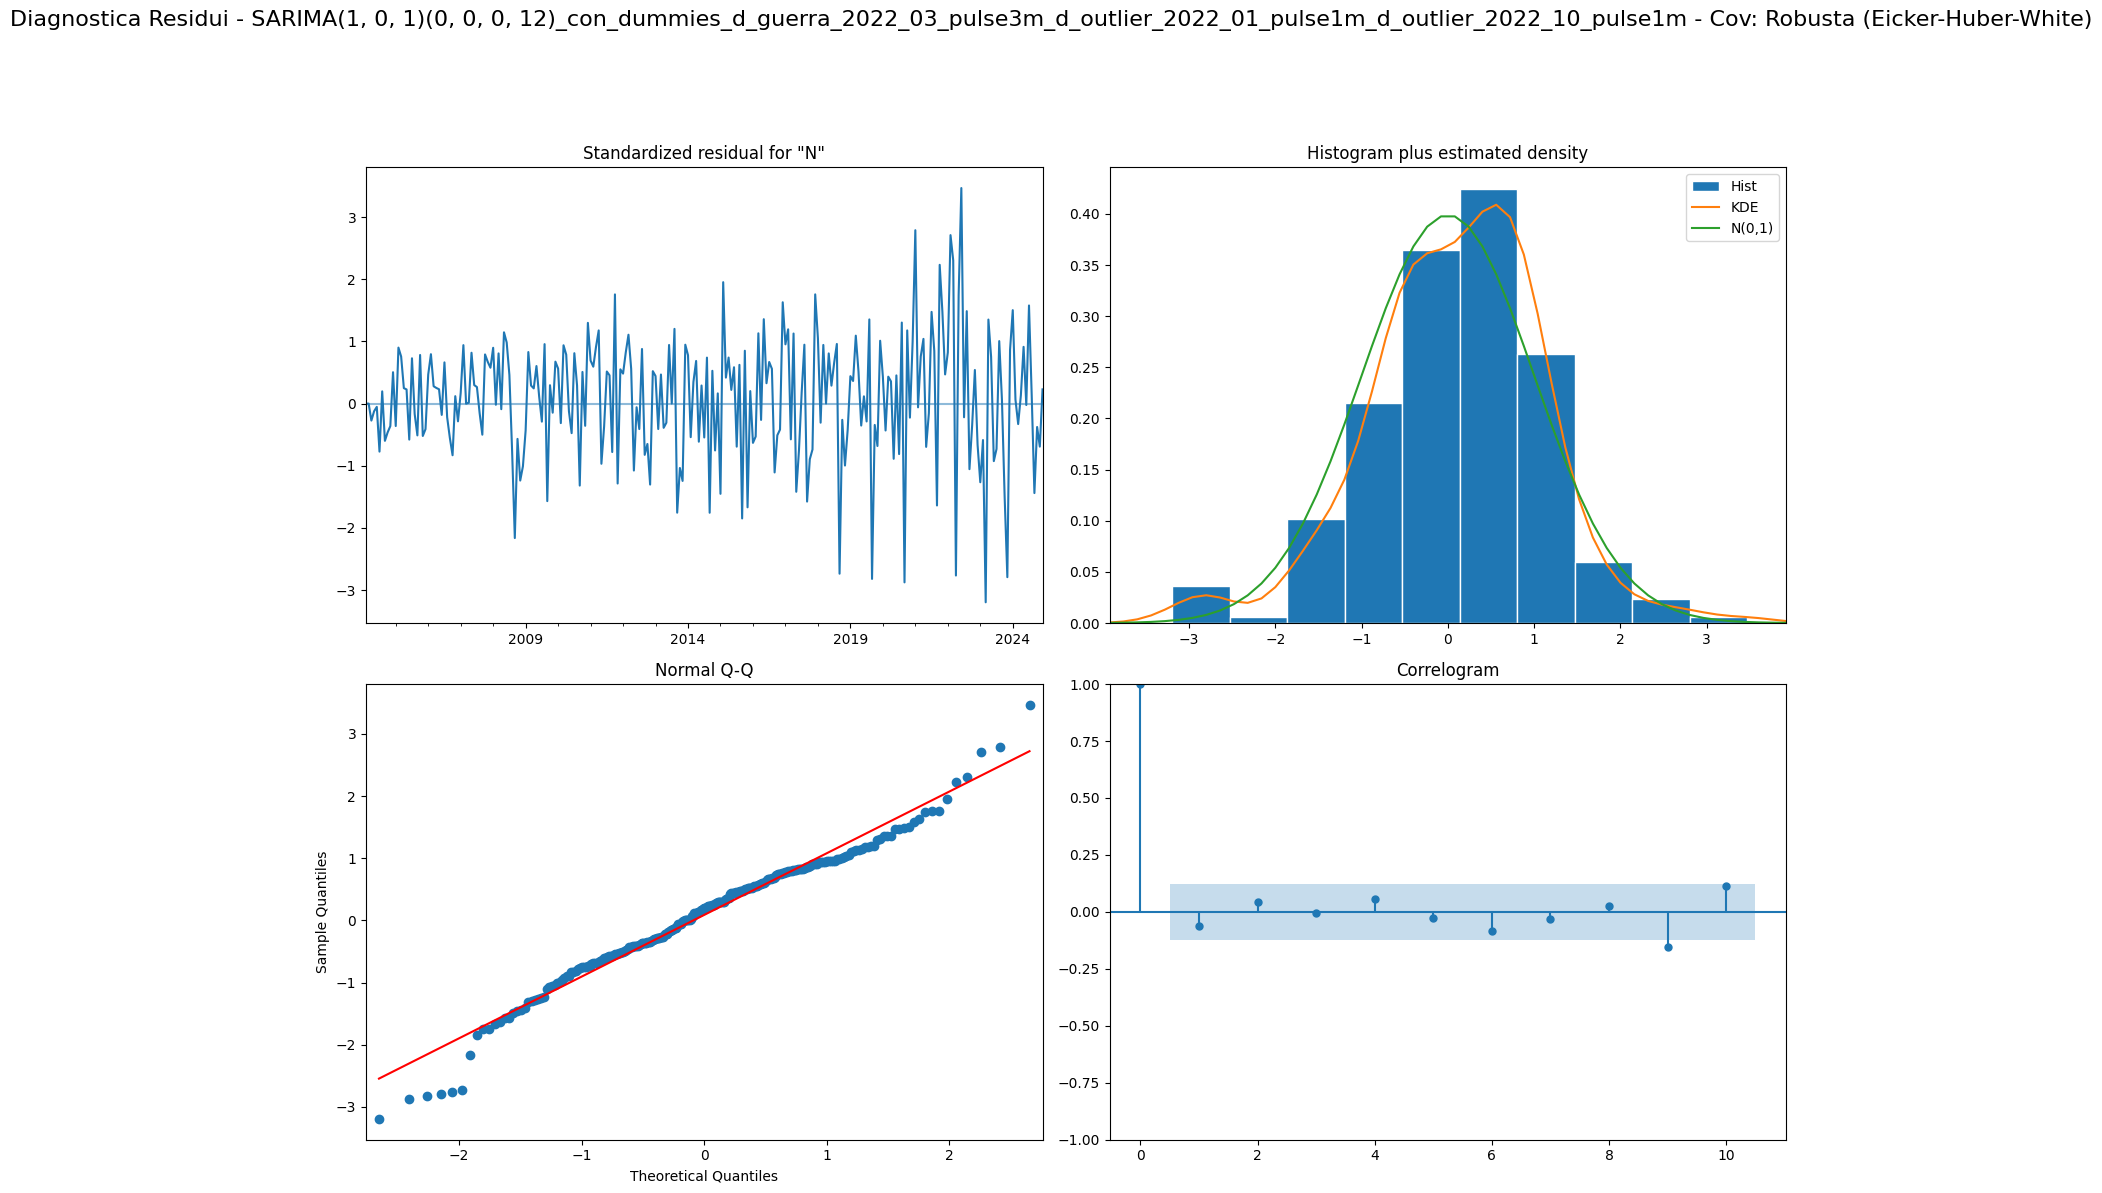


--- Test Statistici sui Residui (dal modello finale) ---
Test di Ljung-Box (lag=10): p-value = 0.1541 (H0: no autocorrelazione)
  -> OK: Residui probabilmente non autocorrelati.
Test di Jarque-Bera (normalità): p-value = 0.0001 (H0: normalità)
  -> ATTENZIONE: Residui potrebbero non essere normali.
--- Fine Diagnostica ---
✓ Miglior modello SARIMAX (Cov: Robusta (Eicker-Huber-White), Dummies: d_guerra_2022_03_pulse3m_d_outlier_2022_01_pulse1m_d_outlier_2022_10_pulse1m) salvato.

>>> SCRIPT MODELLO BASE (CON DUMMIES OUTLIER) COMPLETATO <<<
Tutti i file di output specifici per questa esecuzione sono in: /Users/tommaso/Desktop/tesi-inflation-gt/ARIMAX_modelli/modello_base_outliers_v6
Configurazione Dummies usate: d_guerra_2022_03_pulse3m_d_outlier_2022_01_pulse1m_d_outlier_2022_10_pulse1m


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera
import pickle

# Ignoro i warning di convergenza e altri, per un output più pulito durante la ricerca
warnings.filterwarnings("ignore", category=sm.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIGURAZIONE GENERALE ---
# Definisco i path per i file di input e output.
PATH_INPUT_DIR_FASE2 = "/Users/tommaso/Desktop/tesi-inflation-gt/First_Difference_indexes/dati_preparati_fase2"
FILE_SERIE_STAZIONARIE_IN = os.path.join(PATH_INPUT_DIR_FASE2, "indici_gt_nic_stazionari_fase2.csv")

PATH_OUTPUT_MODELLO_BASE = "/Users/tommaso/Desktop/tesi-inflation-gt/SARIMAX_modelli/modello_base_outliers_v6"

FILE_GRAFICO_ACFPACF_INFL = os.path.join(PATH_OUTPUT_MODELLO_BASE, "acf_pacf_inflazione_staz_outl.png")
FILE_RISULTATI_GRID_SEARCH = os.path.join(PATH_OUTPUT_MODELLO_BASE, "grid_search_sarimax_results_outl.csv")
FILE_GRAFICO_DIAGNOSTICA_BEST = os.path.join(PATH_OUTPUT_MODELLO_BASE, "diagnostica_miglior_modello_outl.png") 
FILE_MODELLO_PICKLE = os.path.join(PATH_OUTPUT_MODELLO_BASE, "miglior_modello_sarimax_outl.pkl")

# Nome della colonna dell'inflazione stazionaria (già differenziata)
COL_INFLAZIONE_STAZ = 'NIC_destag_ISTAT_diff1'

# Parametri per l'analisi ACF/PACF iniziale e la diagnostica dei residui
MAX_LAGS_ACF_PACF = 36
SEASONAL_PERIOD = 12

# Parametri per la Grid Search Automatica degli ordini SARIMA
MAX_P_NON_STAG = 2
MAX_Q_NON_STAG = 2
MAX_P_STAG = 1
MAX_Q_STAG = 1
ORDER_d_NON_STAG = 0 # La mia serie è già I(0) dopo la differenziazione
ORDER_D_STAG = 0     # Presumo che la destagionalizzazione sia stata efficace
CRITERION_SELEZIONE = 'aic'

# --- CONFIGURAZIONE DELLE DUMMY DI INTERVENTO ---
# Definisco le possibili dummy che voglio testare.
# Posso attivarle o disattivarle modificando la lista 'config_dummies_da_includere' nel main.

# DUMMY OUTLIER SPECIFICHE
DUMMY_GEN2022_DATE = '2022-01-01'
DUMMY_GEN2022_DURATION = 1 # Impulso di 1 mese

DUMMY_OTT2022_DATE = '2022-10-01'
DUMMY_OTT2022_DURATION = 1 # Impulso di 1 mese

# DUMMY PER LO SHOCK DELLA GUERRA (dopo aver controllato gli outlier)
DUMMY_MAR2022_DATE = '2022-03-01'
DUMMY_MAR2022_DURATION = 3 # Impulso di 3 mesi


# --- FUNZIONI AUSILIARIE ---
def carica_dati_stazionari(path_file):
    """Carico le mie serie stazionarie dal file CSV."""
    print(f"--- Caricamento Serie Stazionarie da: {path_file} ---")
    try:
        df = pd.read_csv(path_file, index_col=0)
        df.index = pd.to_datetime(df.index)
        print(f"Serie caricate con successo. Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"ERRORE durante il caricamento: {e}")
        return None

def crea_dummy_intervento_specifica(serie_index, breakpoint_date_str, dummy_type="pulse", pulse_duration_months=1, dummy_name_prefix="dummy"):
    """
    Creo una variabile dummy di intervento, "level" o "pulse".
    Per la "pulse", specifico la durata dell'impulso.
    """
    breakpoint_ts = pd.Timestamp(breakpoint_date_str)
    # Costruisco un nome descrittivo per la dummy
    date_suffix = f"{breakpoint_date_str.split('-')[0]}_{breakpoint_date_str.split('-')[1]}"
    if dummy_type == "pulse":
        type_suffix = f"pulse{pulse_duration_months}m"
    else: # level
        type_suffix = "level"
    dummy_name = f"{dummy_name_prefix}_{date_suffix}_{type_suffix}"
    
    dummy = pd.Series(0, index=serie_index, name=dummy_name)

    if dummy_type == "level":
        dummy[serie_index >= breakpoint_ts] = 1
        print(f"Creata dummy di LEVEL SHIFT: {dummy_name} (valore 1 da {breakpoint_ts.strftime('%Y-%m-%d')})")
    elif dummy_type == "pulse":
        start_pulse = breakpoint_ts
        end_pulse = start_pulse + pd.DateOffset(months=pulse_duration_months - 1)
        pulse_period_index = serie_index[(serie_index >= start_pulse) & (serie_index <= end_pulse)]
        if not pulse_period_index.empty:
            dummy[pulse_period_index] = 1
            print(f"Creata dummy di IMPULSO: {dummy_name} (valore 1 da {start_pulse.strftime('%Y-%m-%d')} a {end_pulse.strftime('%Y-%m-%d')}, {len(pulse_period_index)} mesi)")
        else:
            print(f"ATTENZIONE: Nessuna data trovata per l'impulso per {dummy_name}. Dummy sarà tutta zero.")
    else:
        raise ValueError("Tipo di dummy non valido. Scegliere 'level' o 'pulse'.")
    return dummy

def auto_sarima_grid_search(y_series, exog_series=None,
                           max_p=2, max_q=2, max_P=1, max_Q=1,
                           d=0, D=0, s=12,
                           criterion='aic', verbose=True):
    """Eseguo una grid search per trovare i migliori ordini SARIMA(X)."""
    print(f"\n=== INIZIO RICERCA AUTOMATICA ORDINI SARIMA (Criterio: {criterion.upper()}) ===")
    exog_names = "Nessuna"
    if exog_series is not None:
        if isinstance(exog_series, pd.Series):
            exog_names = exog_series.name
        elif isinstance(exog_series, pd.DataFrame):
            exog_names = ", ".join(exog_series.columns)
    print(f"Variabile/i Esogena/e Inlcusa/e: {exog_names}")
    print(f"Range ordini: p<={max_p}, q<={max_q}, P<={max_P}, Q<={max_Q} | d={d}, D={D}, s={s}")
    
    p_rng, q_rng, P_rng, Q_rng = range(max_p+1), range(max_q+1), range(max_P+1), range(max_Q+1)
    all_orders_combinations = list(itertools.product(p_rng, q_rng, P_rng, Q_rng))
    print(f"Numero totale di combinazioni da testare: {len(all_orders_combinations)}")
    
    results_list = []
    for i, (p_val, q_val, P_val, Q_val) in enumerate(all_orders_combinations):
        current_order = (p_val, d, q_val); current_seasonal_order = (P_val, D, Q_val, s)
        if verbose and (i % (len(all_orders_combinations)//10 + 1) == 0 or i == len(all_orders_combinations) - 1) : # Aggiornamenti più frequenti
            print(f"Sto testando il modello {i+1}/{len(all_orders_combinations)}: SARIMA{current_order}{current_seasonal_order}...")
        try:
            model = sm.tsa.SARIMAX(y_series, exog=exog_series, order=current_order, seasonal_order=current_seasonal_order,
                                 enforce_stationarity=False, enforce_invertibility=False,
                                 initialization='approximate_diffuse')
            fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
            current_criterion_val = getattr(fitted_model, criterion.lower())
            lb_lags_to_test = min(10, len(y_series)//5) if len(y_series)//5 > 0 else 1
            lb_pvalue = np.nan
            if lb_lags_to_test > 0 and len(fitted_model.resid) >= lb_lags_to_test : # Controllo aggiuntivo lunghezza residui
                 lb_df = acorr_ljungbox(fitted_model.resid, lags=[lb_lags_to_test], return_df=True)
                 lb_pvalue = lb_df['lb_pvalue'].iloc[0] if not lb_df.empty and 'lb_pvalue' in lb_df.columns else np.nan
            results_list.append({'order': current_order, 'seasonal_order': current_seasonal_order,
                               'AIC': fitted_model.aic, 'BIC': fitted_model.bic,
                               'LogLikelihood': fitted_model.llf, 'LjungBox_pvalue': lb_pvalue,
                               'Converged': fitted_model.mle_retvals.get('converged', False)})
        except Exception: # Errore generico durante la stima
            results_list.append({'order': current_order, 'seasonal_order': current_seasonal_order,
                               'AIC': np.nan, 'BIC': np.nan, 'LogLikelihood': np.nan,
                               'LjungBox_pvalue': np.nan, 'Converged': False})
            
    results_df = pd.DataFrame(results_list)
    valid_results_df = results_df[results_df['Converged'] == True].copy()
    if valid_results_df.empty:
        print("ERRORE: Nessun modello SARIMAX è convergito durante la grid search.")
        return None, None, float('inf'), results_df
    print(f"\n{len(valid_results_df)} modelli sono convergiti con successo su {len(results_df)} testati.")
    valid_results_df = valid_results_df.sort_values(by=[criterion.upper(), 'LjungBox_pvalue'], ascending=[True, False])
    best_model_row = valid_results_df.iloc[0]
    final_best_order = best_model_row['order']
    final_best_seasonal_order = best_model_row['seasonal_order']
    final_best_criterion_val = best_model_row[criterion.upper()]
    print(f"\n=== MIGLIOR MODELLO TROVATO (secondo {criterion.upper()} e Ljung-Box) ===")
    print(f"Ordini: SARIMA{final_best_order}{final_best_seasonal_order}")
    print(f"{criterion.upper()}: {final_best_criterion_val:.3f}, BIC: {best_model_row['BIC']:.3f}, LogLik: {best_model_row['LogLikelihood']:.3f}")
    print(f"Ljung-Box p-value (residui del modello durante grid search): {best_model_row['LjungBox_pvalue']:.3f}")
    if best_model_row['LjungBox_pvalue'] > 0.05 : print("  -> OK: Residui (da grid search) sembrano non autocorrelati.")
    else: print("  -> ATTENZIONE: Residui (da grid search) potrebbero essere autocorrelati.")
    print("=== FINE RICERCA AUTOMATICA ORDINI SARIMA ===\n")
    return final_best_order, final_best_seasonal_order, final_best_criterion_val, valid_results_df

def plot_model_diagnostics_final(fitted_model_results, model_name="Modello", path_output_grafici=None, save_filename="diagnostica_modello.png"):
    """Eseguo la diagnostica grafica e i test statistici sui residui del modello fittato."""
    print(f"\n--- Diagnostica Grafica e Test Residui per: {model_name} ---")
    residuals = fitted_model_results.resid
    try:
        fig = fitted_model_results.plot_diagnostics(figsize=(15, 12))
        fig.suptitle(f"Diagnostica Residui - {model_name}", fontsize=16, y=1.02)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        if path_output_grafici:
            if not os.path.exists(path_output_grafici): os.makedirs(path_output_grafici)
            full_save_path = os.path.join(path_output_grafici, save_filename)
            plt.savefig(full_save_path); print(f"Grafico diagnostica salvato in: {full_save_path}")
        plt.show()
    except Exception as e:
        print(f"ERRORE durante .plot_diagnostics(): {e}. Non sono stati generati i grafici standard.")

    print("\n--- Test Statistici sui Residui (dal modello finale) ---")
    lb_lags_diag = min(10, len(residuals)//5) if len(residuals)//5 > 0 else 1
    if lb_lags_diag > 0 and len(residuals) >= lb_lags_diag :
        lb_df_diag = acorr_ljungbox(residuals, lags=[lb_lags_diag], return_df=True)
        lb_pvalue_diag = lb_df_diag['lb_pvalue'].iloc[0] if not lb_df_diag.empty and 'lb_pvalue' in lb_df_diag.columns else np.nan
        print(f"Test di Ljung-Box (lag={lb_lags_diag}): p-value = {lb_pvalue_diag:.4f} (H0: no autocorrelazione)")
        if lb_pvalue_diag > 0.05: print("  -> OK: Residui probabilmente non autocorrelati.")
        else: print("  -> ATTENZIONE: Residui potrebbero essere autocorrelati.")
    else: print("Test Ljung-Box non eseguibile (serie residui o lag non validi).")
    if len(residuals) > 20: # Jarque-Bera più affidabile con più osservazioni
        jb_stat, jb_pvalue = jarque_bera(residuals)
        print(f"Test di Jarque-Bera (normalità): p-value = {jb_pvalue:.4f} (H0: normalità)")
        if jb_pvalue > 0.05: print("  -> OK: Residui probabilmente normali.")
        else: print("  -> ATTENZIONE: Residui potrebbero non essere normali.")
    else: print("Test Jarque-Bera non eseguito (serie residui troppo corta per un test affidabile).")
    print("--- Fine Diagnostica ---")

# --- ESECUZIONE SCRIPT (ARIMAX_base.ipynb) ---
if __name__ == "__main__":
    print(">>> INIZIO SCRIPT: Costruzione Modello Base SARIMAX con Dummies Outlier e Errori Robusti <<<\n")
    os.makedirs(PATH_OUTPUT_MODELLO_BASE, exist_ok=True) # Creo la cartella di output se non esiste
    print(f"I risultati di questo script verranno salvati in: '{PATH_OUTPUT_MODELLO_BASE}'\n")

    df_serie_stazionarie = carica_dati_stazionari(FILE_SERIE_STAZIONARIE_IN)
    if df_serie_stazionarie is None or COL_INFLAZIONE_STAZ not in df_serie_stazionarie.columns:
        print(f"ERRORE CRITICO: Dati non caricati o colonna '{COL_INFLAZIONE_STAZ}' mancante."); exit()

    y_inflazione = df_serie_stazionarie[COL_INFLAZIONE_STAZ].dropna()
    if y_inflazione.empty: print(f"ERRORE: Serie inflazione '{COL_INFLAZIONE_STAZ}' vuota."); exit()
    print(f"Serie inflazione caricata: {len(y_inflazione)} osservazioni da {y_inflazione.index.min().strftime('%Y-%m')} a {y_inflazione.index.max().strftime('%Y-%m')}")

    # --- DEFINIZIONE E SELEZIONE DELLE DUMMY DA UTILIZZARE IN QUESTA ESECUZIONE ---
    print("\n--- Creazione Potenziali Dummies di Intervento ---")
    dummy_gen2022_outlier = crea_dummy_intervento_specifica(y_inflazione.index, DUMMY_GEN2022_DATE, pulse_duration_months=DUMMY_GEN2022_DURATION, dummy_name_prefix="d_outlier")
    dummy_ott2022_outlier = crea_dummy_intervento_specifica(y_inflazione.index, DUMMY_OTT2022_DATE, pulse_duration_months=DUMMY_OTT2022_DURATION, dummy_name_prefix="d_outlier")
    dummy_mar2022_guerra_pulse3m = crea_dummy_intervento_specifica(y_inflazione.index, DUMMY_MAR2022_DATE, pulse_duration_months=DUMMY_MAR2022_DURATION, dummy_name_prefix="d_guerra")

    # * Configura qui quali dummy includere per questa esecuzione specifica *
    # Esempio 1: Solo outlier di Gennaio e Ottobre
    # config_dummies_da_includere = [dummy_gen2022_outlier, dummy_ott2022_outlier]
    
    # Esempio 2: Outlier di Gennaio e Ottobre + Pulse per Guerra a Marzo
    config_dummies_da_includere = [dummy_gen2022_outlier, dummy_ott2022_outlier, dummy_mar2022_guerra_pulse3m]
    
    # Esempio 3: Solo la pulse per Guerra a Marzo (per testare il tuo dubbio)
    # config_dummies_da_includere = [dummy_mar2022_guerra_pulse3m]

    print("\n--- Dummies Selezionate per questa Esecuzione ---")
    if not config_dummies_da_includere:
        print("Nessuna dummy di intervento selezionata.")
        exog_series_final = None
        active_dummies_name_suffix = "no_dummy"
    else:
        # Allineo gli indici di tutte le dummy selezionate e le converto in float
        aligned_dummies = []
        for d in config_dummies_da_includere:
            aligned_dummies.append(d.reindex(y_inflazione.index, fill_value=0).astype(float))
        
        exog_series_final = pd.concat(aligned_dummies, axis=1)
        print("Variabili esogene (dummies) da includere nel modello:")
        for col in exog_series_final.columns:
            print(f" - {col} (somma: {exog_series_final[col].sum()})")
        active_dummies_name_suffix = "_".join(sorted([d.name for d in config_dummies_da_includere])) # Creo un suffisso per i nomi file
    
    # Aggiorno i nomi dei file di output con il suffisso delle dummy attive
    current_grid_search_file = FILE_RISULTATI_GRID_SEARCH.replace(".csv", f"_{active_dummies_name_suffix}.csv")
    current_diagnostics_file_name = f"diagnostica_{active_dummies_name_suffix}.png" # Verrà usato in plot_model_diagnostics_final
    current_model_pickle_file = FILE_MODELLO_PICKLE.replace(".pkl", f"_{active_dummies_name_suffix}.pkl")


    print(f"\n--- Analisi ACF/PACF per: {COL_INFLAZIONE_STAZ} (guida visuale) ---")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[0], title=f"ACF - {COL_INFLAZIONE_STAZ}")
    axes[0].grid(True, alpha=0.5); plot_pacf(y_inflazione, lags=MAX_LAGS_ACF_PACF, ax=axes[1], title=f"PACF - {COL_INFLAZIONE_STAZ}", method='ols')
    axes[1].grid(True, alpha=0.5); plt.tight_layout(); plt.savefig(FILE_GRAFICO_ACFPACF_INFL); plt.show()

    print(f"\n--- Inizio Grid Search (con dummies: {active_dummies_name_suffix}) ---")
    best_order, best_seasonal_order, _, grid_search_results_df = auto_sarima_grid_search(
        y_inflazione, exog_series=exog_series_final,
        max_p=MAX_P_NON_STAG, max_q=MAX_Q_NON_STAG, max_P=MAX_P_STAG, max_Q=MAX_Q_STAG,
        d=ORDER_d_NON_STAG, D=ORDER_D_STAG, s=SEASONAL_PERIOD, criterion=CRITERION_SELEZIONE)

    if grid_search_results_df is not None:
        grid_search_results_df.to_csv(current_grid_search_file, index=False)
        print(f"Risultati grid search salvati in: {current_grid_search_file}")

    if best_order and best_seasonal_order:
        model_desc_for_label = f"SARIMA{best_order}{best_seasonal_order}_con_dummies_{active_dummies_name_suffix}"
        print(f"\n--- Stima Finale e Diagnostica del Miglior Modello: {model_desc_for_label} ---")
        
        final_model_def = sm.tsa.SARIMAX(y_inflazione, exog=exog_series_final, order=best_order,
                                         seasonal_order=best_seasonal_order, enforce_stationarity=False,
                                         enforce_invertibility=False, initialization='approximate_diffuse')
        
        fitted_results_final = None; final_cov_type_used = "Non Robusta (Default)"

        print(f"Sto tentando la stima del modello con errori standard HAC (Newey-West)...")
        try:
            fitted_results_final = final_model_def.fit(disp=False, maxiter=250, cov_type='HAC',
                                                     cov_kwds={'kernel': 'bartlett', 'use_correction': True})
            final_cov_type_used = "HAC (Newey-West)"; print("Stima con errori HAC completata.")
        except Exception as e_hac:
            print(f"✗ ERRORE stima HAC: {e_hac}. Tento con 'robust'...")
            try:
                fitted_results_final = final_model_def.fit(disp=False, maxiter=250, cov_type='robust')
                final_cov_type_used = "Robusta (Eicker-Huber-White)"; print("Stima con errori 'robust' completata.")
            except Exception as e_robust:
                print(f"✗ ERRORE stima 'robust': {e_robust}. Tento con default...")
                try:
                    fitted_results_final = final_model_def.fit(disp=False, maxiter=250)
                    print("Stima con errori default completata. Inferenza meno affidabile.")
                except Exception as e_default: print(f"✗ ERRORE CRITICO stima default: {e_default}")
        
        if fitted_results_final:
            final_model_display_name = f"{model_desc_for_label} - Cov: {final_cov_type_used}"
            print(f"\n--- Sommario Miglior Modello ({final_cov_type_used}) ---")
            print(fitted_results_final.summary())

            # Stampa significatività delle dummy incluse
            if exog_series_final is not None:
                print(f"\n--- Risultati Dummies Incluse (dal modello {final_cov_type_used}) ---")
                for dummy_col_name in exog_series_final.columns:
                    if dummy_col_name in fitted_results_final.params.index:
                        coeff = fitted_results_final.params[dummy_col_name]
                        p_val = fitted_results_final.pvalues[dummy_col_name]
                        print(f"Dummy: {dummy_col_name} | Coeff: {coeff:.4f} | P-value: {p_val:.4f} | Signif. (5%): {'SÌ' if p_val < 0.05 else 'NO'}")
                    else:
                        print(f"ATTENZIONE: La dummy {dummy_col_name} non è presente nei parametri del modello finale.")
            
            plot_model_diagnostics_final(fitted_results_final, model_name=final_model_display_name,
                                         path_output_grafici=PATH_OUTPUT_MODELLO_BASE,
                                         save_filename=current_diagnostics_file_name.replace(".png", f"_{final_cov_type_used.split(' ')[0].lower()}.png"))
            
            with open(current_model_pickle_file.replace(".pkl", f"_{final_cov_type_used.split(' ')[0].lower()}.pkl"), 'wb') as pkl_f:
                pickle.dump(fitted_results_final, pkl_f)
            print(f"✓ Miglior modello SARIMAX (Cov: {final_cov_type_used}, Dummies: {active_dummies_name_suffix}) salvato.")
        else:
            print("✗ La stima del modello finale è fallita con tutti i tipi di covarianza tentati.")
    else:
        print("\n✗ Nessun modello ottimale trovato dalla grid search. Impossibile procedere.")

    print(f"\n>>> SCRIPT MODELLO BASE (CON DUMMIES OUTLIER) COMPLETATO <<<")
    print(f"Tutti i file di output specifici per questa esecuzione sono in: {PATH_OUTPUT_MODELLO_BASE}")
    print(f"Configurazione Dummies usate: {active_dummies_name_suffix}")
